In [2]:
#Encoding
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


DATA_DIR = Path('..','Desktop','BDProject')

train_values = pd.read_csv('/Users/ShaimaShoukat/Desktop/BDProject/train_values.csv', index_col='building_id')
train_labels = pd.read_csv('/Users/ShaimaShoukat/Desktop/BDProject/train_labels.csv', index_col='building_id')
test_values = pd.read_csv('/Users/ShaimaShoukat/Desktop/BDProject/test_values.csv', index_col='building_id')

#Missing values
dataset = pd.concat(objs=[train_values, test_values], axis=0)


#one-hot encoding categorical features
train_values = train_values.drop(['geo_level_2_id', 'geo_level_3_id'], axis=1)
#test_values = test_values.drop(['geo_level_2_id', 'geo_level_3_id'], axis=1)


/Users/ShaimaShoukat/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(train_values,train_labels, test_size = 0.20, random_state = 42)

In [4]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(208480, 36)
(52121, 36)
(208480, 1)
(52121, 1)


# Pre-Processing

In [5]:
train_values1=pd.get_dummies(X_train, columns=['foundation_type','land_surface_condition','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'],drop_first=True)
test_values_subset = pd.get_dummies(test_values, columns=['foundation_type','land_surface_condition','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'],drop_first=True)
X_val_sub = pd.get_dummies(X_val, columns=['foundation_type','land_surface_condition','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'],drop_first=True)


# K-Fold Target Encoding

In [6]:
from sklearn import base
from sklearn.model_selection import KFold

class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=2019)
        col_mean_name = self.colnames + '_' + 'Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X



In [7]:
train = train_values1
train['damage_grade'] = Y_train['damage_grade']
targetc = KFoldTargetEncoderTrain('geo_level_1_id','damage_grade',n_fold=5)
new_train = targetc.fit_transform(train)
new_train = new_train.drop(['damage_grade'], axis=1)
new_train.head(100) 

Correlation between the new feature, geo_level_1_id_Enc and, damage_grade is 0.4691310950706527.


,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,geo_level_1_id_Enc
building_id,,,,,,,,,,,,,,,,,,,,,
739427,13,3,25,2,5,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1.946461
17201,6,3,40,10,8,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,2.162207
723805,7,2,45,8,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,2.301670
891512,7,2,30,7,4,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,2.301670
484350,17,3,30,6,7,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,2.792889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760138,13,2,5,3,5,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,1.940631
910188,12,2,25,3,5,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,2.144295
684277,17,3,70,7,7,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,2.792889


In [8]:
print(new_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(208480, 59)
(52121, 36)
(208480, 1)
(52121, 1)


# Feature importance

In [9]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(new_train,Y_train)
np.set_printoptions(precision=10)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(new_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(30,'Score'))  

                                     Specs         Score
2                                      age  62369.928203
37                     ground_floor_type_v  25757.831356
35                             roof_type_x  22146.731196
28                       foundation_type_i  22002.394382
0                           geo_level_1_id  19647.855819
10  has_superstructure_cement_mortar_brick  15157.335845
41                      other_floor_type_s  14668.376103
14        has_superstructure_rc_engineered  11387.238389
3                          area_percentage   9347.876129
13    has_superstructure_rc_non_engineered   6943.766676
31                       foundation_type_w   6539.311207
6      has_superstructure_mud_mortar_stone   5498.294997
29                       foundation_type_r   5078.481797
30                       foundation_type_u   4485.961126
40                      other_floor_type_q   4049.332789
19                 has_secondary_use_hotel   2245.181280
20                has_secondary

In [10]:
features = ['geo_level_1_id','count_floors_pre_eq','age','area_percentage','foundation_type','roof_type','ground_floor_type','other_floor_type','has_superstructure_adobe_mud','has_superstructure_mud_mortar_stone','has_superstructure_mud_mortar_brick','has_superstructure_cement_mortar_brick','has_superstructure_timber','has_superstructure_bamboo','has_superstructure_rc_non_engineered','legal_ownership_status','has_secondary_use_hotel','has_secondary_use_rental','has_superstructure_rc_engineered','has_secondary_use','plan_configuration']
new_train = X_train[features]
test_values = test_values[features]
X_val = X_val[features]
new_train=pd.get_dummies(new_train, columns=['foundation_type','roof_type','ground_floor_type','other_floor_type','plan_configuration','legal_ownership_status'],drop_first=True)
test_values_subset = pd.get_dummies(test_values, columns=['foundation_type','roof_type','ground_floor_type','other_floor_type','plan_configuration','legal_ownership_status'],drop_first=True)
X_val =  pd.get_dummies(X_val, columns=['foundation_type','roof_type','ground_floor_type','other_floor_type','plan_configuration','legal_ownership_status'],drop_first=True)


In [11]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(208480, 36)
(52121, 40)
(208480, 1)
(52121, 1)


In [12]:
new_train['damage_grade'] = Y_train['damage_grade']
targetc = KFoldTargetEncoderTrain('geo_level_1_id','damage_grade',n_fold=5)
new_train = targetc.fit_transform(new_train)
new_train = new_train.drop(['damage_grade'], axis=1)
new_train.head(100) 

Correlation between the new feature, geo_level_1_id_Enc and, damage_grade is 0.4691310950706527.


,geo_level_1_id,count_floors_pre_eq,age,area_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,geo_level_1_id_Enc
building_id,,,,,,,,,,,,,,,,,,,,,
739427,13,3,25,2,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1.946461
17201,6,3,40,10,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2.162207
723805,7,2,45,8,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.301670
891512,7,2,30,7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2.301670
484350,17,3,30,6,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2.792889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760138,13,2,5,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.940631
910188,12,2,25,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2.144295
684277,17,3,70,7,1,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2.792889


# over sampling 

In [14]:

from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')
train_values_sm,train_labels_sm = smote.fit_sample(new_train,Y_train.values.ravel())
print(train_values_sm.shape,train_labels_sm.shape)

Using TensorFlow backend.


(307298, 41) (307298,)


# Random Forests

In [1]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=2018))

In [24]:
param_grid = {'randomforestclassifier__n_estimators': [85,90,95],
              'randomforestclassifier__min_samples_leaf': [1, 5],
            'randomforestclassifier__max_depth':list(np.linspace(15, 20).astype(int)),
              'randomforestclassifier__max_features' : ['sqrt'],
             'randomforestclassifier__max_leaf_nodes': [65]}
gs = GridSearchCV(pipe, param_grid, cv=5,verbose = 3,n_jobs=-1)
gs.fit(train_values_sm, train_labels_sm)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 69.2min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 132.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 213.2min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 293.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 385.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decre

In [44]:
gs.best_params_
dt_model = gs.best_estimator_

In [45]:
gs.best_params_
from graphviz import Source
from sklearn import tree
Source( tree.export_graphviz(dtreg, out_file=None, feature_names=X.columns))

{'randomforestclassifier__max_depth': 17,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': 65,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__n_estimators': 95}

In [91]:
from sklearn.metrics import f1_score

in_sample_preds = gs.predict(train_values_sm)
f1_score(train_labels_sm, in_sample_preds, average='micro')

0.7893499697708841

In [18]:
import pickle
filename = 'finalized_RF.sav'
#pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)


FileNotFoundError: [Errno 2] No such file or directory: 'finalized_RF.sav'

In [30]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        mean =  self.train[[self.colNames,
                self.encodedName]].groupby(
                                self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
        return X

In [41]:
from sklearn.metrics import f1_score
val_targetc = KFoldTargetEncoderTest(new_train,
                                      'geo_level_1_id',
                                      'geo_level_1_id_Enc')
X_val = val_targetc.fit_transform(X_val)
predictions_V = gs.predict(X_val)
f1_score(Y_val, predictions_V, average='micro')

0.6259856871510524

In [33]:
test_targetc = KFoldTargetEncoderTest(new_train,
                                      'geo_level_1_id',
                                      'geo_level_1_id_Enc')
new_test = test_targetc.fit_transform(test_values_subset)

In [35]:
predictions = gs.predict(new_test)

In [36]:
submission_format = pd.read_csv('/Users/ShaimaShoukat/Desktop/BDProject/submission_format.csv', index_col='building_id')

In [37]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [38]:
my_submission.to_csv('submissionFT.csv')

In [19]:
param_grid = {'randomforestclassifier__n_estimators': np.linspace(50, 110).astype(int),
             'randomforestclassifier__max_depth':list(np.linspace(7, 20).astype(int)),
             'randomforestclassifier__max_features': ['auto'],
              'randomforestclassifier__max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
             'randomforestclassifier__min_samples_split': [5,10],
             'randomforestclassifier__bootstrap': [True]}
gs2 = RandomizedSearchCV(pipe, param_grid, cv=5,verbose=2,n_jobs=-1)
gs2.fit(train_values_sm, train_labels_sm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('standardscaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
   

In [25]:
gs2.best_params_

NameError: name 'gs2' is not defined

In [1]:
best_model = gs2.best_estimator_

NameError: name 'gs2' is not defined

In [ ]:
import pickle
filename = 'finalized_RF.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)


In [39]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

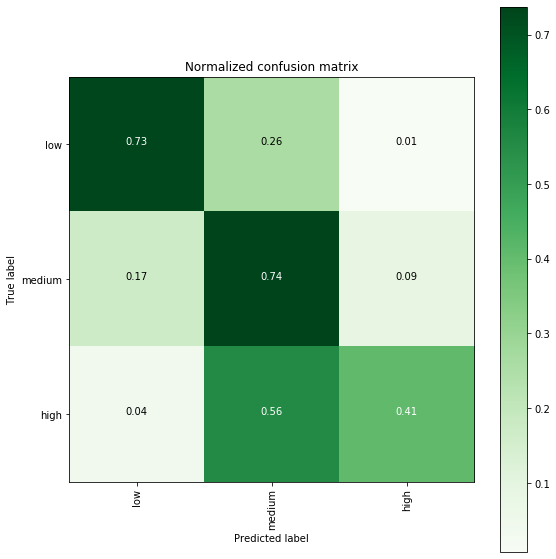

-------------------------
| Classifiction Report |
              precision    recall  f1-score   support

           1       0.40      0.73      0.52      5170
           2       0.66      0.74      0.70     29487
           3       0.72      0.41      0.52     17464

    accuracy                           0.63     52121
   macro avg       0.59      0.63      0.58     52121
weighted avg       0.66      0.63      0.62     52121



In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
class_labels = ['low','medium','high']
# confusion matrix
cm = metrics.confusion_matrix(Y_val, predictions_V)
    
# plot confusin matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()

# get classification report
print('-------------------------')
print('| Classifiction Report |')
classification_report = metrics.classification_report(Y_val, predictions_V)
print(classification_report)




In [ ]:
n_nodes = []
max_depths = []

for ind_tree in best_model.best_estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

In [ ]:
https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b
https://github.com/pourya-ir/Medium/blob/master/K-fold-target-enc/K-fold-Target-Encoding.ipynb
http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html
https://docs.featuretools.com/api_reference.html#feature-encoding
https://github.com/FeatureLabs/categorical_encoding/blob/master/guides/notebooks/categorical-encoding-DEMO.ipynb
https://mlwhiz.com/blog/2019/05/19/feature_extraction/